In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U efficientnet
!pip install -U git+https://github.com/qubvel/efficientnet
!pip install -U --pre efficientnet

     |████████████████████████████████| 51kB 8.1MB/s 
  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-r4sooehy
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-r4sooehy
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp37-none-any.whl size=18421 sha256=ade4794a0b1dba0bf48265368878658c94d6a0c5ad683d6665a2fb92c5d0c26a
  Stored in directory: /tmp/pip-ephem-wheel-cache-up8w92b5/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
  Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1
Requirement already up-to-date: efficientnet in /usr/local/lib/python3.7/dist-packages (1.1.1)


In [4]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=7aa3dce184ad917dba88669bcf31cc5a60efe5d7b0b319b6a8edfce85ed23a73
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [5]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b0')

In [6]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [7]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

# ... image preprocessing as in the classification example ...
print(img.shape) # torch.Size([1, 3, 224, 224])

features = model.extract_features(img)
print(features.shape) # torch.Size([1, 1280, 7, 7])

Loaded pretrained weights for efficientnet-b0


NameError: ignored

In [8]:
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'  # b5

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=12)

224
Loaded pretrained weights for efficientnet-b0


In [9]:
batch_size  = 128
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

## make dataset
from torchvision import transforms, datasets
data_path = './drive/MyDrive/mushroom_project/new_mush/'  # class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다
mush_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]))
## data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_idx, tmp_idx = train_test_split(list(range(len(mush_dataset))), test_size=0.2, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(mush_dataset, train_idx)
tmp_dataset       = Subset(mush_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test']  = Subset(tmp_dataset, test_idx)

## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 128,  tvt : 15 / 2 / 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [13]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.67 Acc: 55.2
valid Loss: 0.83 Acc: 70.7
==> best model saved - 0 / 70.7
Epoch 1/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.31 Acc: 90.2
valid Loss: 1.97 Acc: 65.7
Epoch 2/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.10 Acc: 96.7
valid Loss: 1.40 Acc: 77.4
==> best model saved - 2 / 77.4
Epoch 3/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.06 Acc: 98.1
valid Loss: 0.83 Acc: 84.1
==> best model saved - 3 / 84.1
Epoch 4/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.03 Acc: 99.3
valid Loss: 0.55 Acc: 86.2
==> best model saved - 4 / 86.2
Epoch 5/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.02 Acc: 99.6
valid Loss: 0.82 Acc: 86.2
Epoch 6/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.01 Acc: 99.9
valid Loss: 0.61 Acc: 87.4
==> best model saved - 6 / 87.4
Epoch 7/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.01 Acc: 99.9
valid Loss: 0.45 Acc: 88.3
==> best model saved - 7 / 88.3
Epoch 8/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.01 Acc: 99.9
valid Loss: 0.30 Acc: 92.1
==> best model saved - 8 / 92.1
Epoch 9/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 99.9
valid Loss: 0.30 Acc: 92.5
==> best model saved - 9 / 92.5
Epoch 10/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.27 Acc: 91.6
Epoch 11/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 99.9
valid Loss: 0.27 Acc: 92.1
Epoch 12/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.26 Acc: 92.1
Epoch 13/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.26 Acc: 91.6
Epoch 14/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.25 Acc: 92.1
Epoch 15/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.24 Acc: 92.5
Epoch 16/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.23 Acc: 92.9
==> best model saved - 16 / 92.9
Epoch 17/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.22 Acc: 92.9
Epoch 18/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.22 Acc: 92.9
Epoch 19/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.22 Acc: 93.3
==> best model saved - 19 / 93.3
Epoch 20/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.22 Acc: 93.3
Epoch 21/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.22 Acc: 93.3
Epoch 22/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.22 Acc: 93.7
==> best model saved - 22 / 93.7
Epoch 23/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.22 Acc: 93.7
Epoch 24/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.21 Acc: 93.3
Epoch 25/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 99.9
valid Loss: 0.21 Acc: 93.7
Epoch 26/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 99.9
valid Loss: 0.21 Acc: 93.3
Epoch 27/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.21 Acc: 92.9
Epoch 28/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.21 Acc: 92.9
Epoch 29/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.21 Acc: 93.7
Epoch 30/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.21 Acc: 93.3
Epoch 31/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.21 Acc: 93.7
Epoch 32/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.22 Acc: 93.7
Epoch 33/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.21 Acc: 93.7
Epoch 34/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.26 Acc: 92.1
Epoch 35/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.29 Acc: 91.6
Epoch 36/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 99.9
valid Loss: 0.24 Acc: 92.5
Epoch 37/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 99.9
valid Loss: 0.24 Acc: 92.9
Epoch 38/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 99.9
valid Loss: 0.21 Acc: 93.7
Epoch 39/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.21 Acc: 94.1
==> best model saved - 39 / 94.1
Epoch 40/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.21 Acc: 94.1
Epoch 41/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.20 Acc: 94.1
Epoch 42/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.20 Acc: 93.7
Epoch 43/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.20 Acc: 93.7
Epoch 44/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 99.9
valid Loss: 0.20 Acc: 93.7
Epoch 45/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.19 Acc: 93.7
Epoch 46/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.20 Acc: 93.7
Epoch 47/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.20 Acc: 93.7
Epoch 48/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.20 Acc: 94.1
Epoch 49/49
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.00 Acc: 100.0
valid Loss: 0.19 Acc: 93.7
Training complete in 18m 24s
Best valid Acc: 39 - 94.1
model saved


best model : 39 - 94 / 0.2


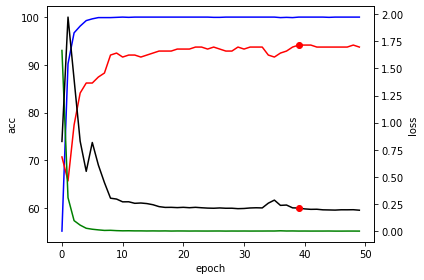

In [14]:
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()